In [1]:
# training a model with pre-defined (and saved) train / test datasets
# here we repeat the steps from DLRM_train_test_split but prepare the data for the model by (i) method # used in pytorch example and (ii) use Integer Encoding (from kaggle)

In [2]:
# reading the data ml-latest-small
import pandas as pd
import zipfile
import numpy as np 
zf = zipfile.ZipFile('/home/elena/Downloads/ml-latest-small.zip')
# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(zf.open('ml-latest-small/ratings.csv'), names=r_cols)
m_cols=['movie_id', 'title', 'genre']
movies = pd.read_csv(zf.open('ml-latest-small/movies.csv'), names=m_cols)
# merging ratings and movies
ratings=pd.merge(ratings,movies,on='movie_id')
ratings.head()

,user_id,movie_id,rating,unix_timestamp,title,genre
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [4]:
def create_dataset(ratings):
    unique_movies = ratings.movie_id.unique() # returns a np array
    movie_to_index = {old: new for new, old in enumerate(unique_movies)} # indexing movie_id, tart at 0
    index_to_movie = {idx: movie for movie, idx in movie_to_index.items()}
    new_movies = ratings.movie_id.map(movie_to_index) # replaces movie_id with coresp. index
    ratings['movie_index']=new_movies

    train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
    test=pd.read_pickle('/home/elena/Downloads/testdata.pkl')
    train['movie_index']=train.movie_id.map(movie_to_index)
    test['movie_index']=test.movie_id.map(movie_to_index)

    X_train=train.drop('rating',axis=1)
    X_test=test.drop('rating', axis=1)

    y_train = train['rating'].astype(np.float32)
    y_test=test['rating'].astype(np.float32)
    return (X_train, y_train), (X_test,y_test)

In [5]:
(X_train, y_train), (X_test,y_test) = create_dataset(ratings)

In [6]:
X_train.head()

,user_id,age,sex,occupation,zip_code,movie_id,unix_timestamp,title,genre,movie_index
97717,606,28,M,programmer,63044,3462,1171501099,Modern Times (1936),Comedy|Drama|Romance,1185
100124,610,22,M,student,21227,8914,1493845360,Primer (2004),Drama|Sci-Fi,2266
25952,180,22,F,administrator,60202,1196,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,68
25871,178,26,M,other,49512,2231,1163673637,Rounders (1998),Drama,2183
97255,605,33,M,engineer,33716,1588,1277094877,George of the Jungle (1997),Children|Comedy,1495


In [7]:
# Implementation 
from keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dot, Add, Multiply, Subtract, Average
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [8]:
def embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value,merging_method):
    # Each instance will consist of two inputs: a single user id, and a single movie id
    user_id_input = Input(shape=(1,), name='user_id')
    movie_id_input = Input(shape=(1,), name='movie_id')
    # Embeddings
    user_embedded = Embedding(user_max_cat_value+1, user_embedding_dim, 
                                       input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = Embedding(movie_max_cat_value+1, movie_embedding_dim, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
    # merging the embeddings
    if merging_method=='concatenate':
        merged = Concatenate()([user_embedded, movie_embedded])
    if merging_method=='dot_product':
        merged =Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedded, movie_embedded])
    if merging_method=='add':
        merged =Add()([user_embedded, movie_embedded])
    if merging_method=='substract':
        merged=Subtract()([user_embedded, movie_embedded])
    if merging_method=='multiply':
        merged=Multiply()([user_embedded, movie_embedded])
    if merging_method=='average':
        merged=Average()([user_embedded, movie_embedded])
    out = Flatten()(merged)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = Dense(1, activation='linear', name='prediction')(out)
    model = Model(inputs = [user_id_input, movie_id_input],outputs = out)
    model.compile(optimizer = 'Adam',loss='MSE',metrics=['MAE'])
    return model

In [10]:
# parameters for the models used
hidden_units = (100,50) #same as in pytorch model
movie_embedding_dim = 50 #same as in pytorch model
user_embedding_dim = 50  #same as in pytorch model
user_max_cat_value = ratings.user_id.max()
movie_max_cat_value=max(X_train.movie_index.max(), X_test.movie_index.max())
es=EarlyStopping(monitor='val_MAE', min_delta=0, patience=0, verbose=0, mode='min', baseline=None, restore_best_weights=False)

In [11]:
model_concatenate=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='concatenate')
# model_concatenate.summary(line_length=88)
history= model_concatenate.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 3.2851 - MAE: 1.3295 - val_loss: 0.7866 - val_MAE: 0.6844
Epoch 2/10
 - 3s - loss: 0.7325 - MAE: 0.6582 - val_loss: 0.7711 - val_MAE: 0.6770
Epoch 3/10
 - 3s - loss: 0.6955 - MAE: 0.6387 - val_loss: 0.7707 - val_MAE: 0.6762
Epoch 4/10
 - 3s - loss: 0.6803 - MAE: 0.6310 - val_loss: 0.7736 - val_MAE: 0.6789


In [17]:
# 1. run
# Epoch 5/10  - 3s - loss: 0.6666 - MAE: 0.6232 - val_loss: 0.7697 - val_MAE: 0.6755
# compare to 
#  Epch 4/19 - 48s - loss: 0.6777 - MAE: 0.6295 - val_loss: 0.7709 - val_MAE: 0.6740

In [20]:
val_MAE_concat=history.history['val_MAE']
MAE_concat=history.history['MAE']
loss_concat=history.history['loss']
val_loss_concat=history.history['val_loss']
epoch_concat=history.epoch

In [24]:
model_dot=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='dot_product')
history= model_dot.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 4.5639 - MAE: 1.6829 - val_loss: 1.0825 - val_MAE: 0.8241
Epoch 2/10
 - 3s - loss: 1.0645 - MAE: 0.8238 - val_loss: 1.0849 - val_MAE: 0.8345


In [19]:
# 1 .run
# Epoch 2/10  - 3s - loss: 1.0619 - MAE: 0.8205 - val_loss: 1.0836 - val_MAE: 0.8289
# compare to without data prep
# Epoch 2/10  - 57s - loss: 1.0672 - MAE: 0.8238 - val_loss: 1.0869 - val_MAE: 0.8376

In [25]:
val_MAE_dot=history.history['val_MAE']
MAE_dot=history.history['MAE']
loss_dot=history.history['loss']
val_loss_dot=history.history['val_loss']
epoch_dot=history.epoch

In [27]:
model_add=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='add')
history= model_add.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 2.7490 - MAE: 1.2074 - val_loss: 0.7888 - val_MAE: 0.6889
Epoch 2/10
 - 3s - loss: 0.7241 - MAE: 0.6556 - val_loss: 0.7723 - val_MAE: 0.6783
Epoch 3/10
 - 3s - loss: 0.6811 - MAE: 0.6317 - val_loss: 0.7680 - val_MAE: 0.6755
Epoch 4/10
 - 3s - loss: 0.6549 - MAE: 0.6178 - val_loss: 0.7701 - val_MAE: 0.6746
Epoch 5/10
 - 3s - loss: 0.6249 - MAE: 0.6011 - val_loss: 0.7715 - val_MAE: 0.6746


In [21]:
# 2.run 
# Epoch 6/10  - 4s - loss: 0.6315 - MAE: 0.6038 - val_loss: 0.7760 - val_MAE: 0.6793
#1. run
# Epoch 5/10  - 3s - loss: 0.6584 - MAE: 0.6184 - val_loss: 0.7721 - val_MAE: 0.6755
# compare to without data prep
# Epoch 3/10 - 32s - loss: 0.6899 - MAE: 0.6363 - val_loss: 0.7743 - val_MAE: 0.6801

In [28]:
val_MAE_add=history.history['val_MAE']
MAE_add=history.history['MAE']
loss_add=history.history['loss']
val_loss_add=history.history['val_loss']
epoch_add=history.epoch

In [29]:
model_substract=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='substract')
history= model_substract.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 3.1393 - MAE: 1.3001 - val_loss: 0.8001 - val_MAE: 0.6886
Epoch 2/10
 - 3s - loss: 0.7368 - MAE: 0.6608 - val_loss: 0.7810 - val_MAE: 0.6808
Epoch 3/10
 - 3s - loss: 0.6951 - MAE: 0.6394 - val_loss: 0.7767 - val_MAE: 0.6777
Epoch 4/10
 - 3s - loss: 0.6776 - MAE: 0.6290 - val_loss: 0.7776 - val_MAE: 0.6745
Epoch 5/10
 - 3s - loss: 0.6659 - MAE: 0.6221 - val_loss: 0.7742 - val_MAE: 0.6750


In [33]:
# 1.Run 
# Epoch 6/10  - 3s - loss: 0.6457 - MAE: 0.6108 - val_loss: 0.7733 - val_MAE: 0.6769
# compare to without data prep
# Epoch 7/10  - 46s - loss: 0.6186 - MAE: 0.5960 - val_loss: 0.7775 - val_MAE: 0.6773

In [30]:
val_MAE_sub=history.history['val_MAE']
MAE_subb=history.history['MAE']
loss_subb=history.history['loss']
val_loss_subb=history.history['val_loss']
epoch_subb=history.epoch

In [31]:
model_multiply=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='multiply')
history= model_multiply.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 4.0744 - MAE: 1.5724 - val_loss: 1.0762 - val_MAE: 0.8218
Epoch 2/10
 - 3s - loss: 0.9299 - MAE: 0.7575 - val_loss: 0.8795 - val_MAE: 0.7292
Epoch 3/10
 - 3s - loss: 0.4658 - MAE: 0.5181 - val_loss: 0.9078 - val_MAE: 0.7412


In [24]:
# 1.Run
# Epoch 3/10  - 3s - loss: 0.4896 - MAE: 0.5309 - val_loss: 0.8846 - val_MAE: 0.7308
# compare to without data prep
# Epoch 3/10  - 46s - loss: 0.4674 - MAE: 0.5177 - val_loss: 0.8758 - val_MAE: 0.7270

In [32]:
val_MAE_mult=history.history['val_MAE']
MAE_mult=history.history['MAE']
loss_mult=history.history['loss']
val_loss_mult=history.history['val_loss']
epoch_mult=history.epoch

In [34]:
model_average=embedding_model(hidden_units, user_embedding_dim, user_max_cat_value, movie_embedding_dim, movie_max_cat_value, merging_method='average')
history= model_average.fit(x=[X_train.user_id, X_train.movie_index], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test.user_id, X_test.movie_index],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 3.4200 - MAE: 1.3647 - val_loss: 0.7865 - val_MAE: 0.6867
Epoch 2/10
 - 3s - loss: 0.7308 - MAE: 0.6578 - val_loss: 0.7672 - val_MAE: 0.6724
Epoch 3/10
 - 4s - loss: 0.6905 - MAE: 0.6365 - val_loss: 0.7674 - val_MAE: 0.6741


In [35]:
val_MAE_av=history.history['val_MAE']
MAE_av=history.history['MAE']
loss_av=history.history['loss']
val_loss_av=history.history['val_loss']
epoch_av=history.epoch

In [47]:
val_MAE=(val_MAE_concat, val_MAE_dot, val_MAE_add, val_MAE_sub, val_MAE_mult, val_MAE_av)
import operator
min_index, min_value = min(enumerate(val_MAE), key=operator.itemgetter(1))
min_index, min_value 
# model concat with the lowest val_MAE

(0,
 [0.6843906044960022,
  0.6769842505455017,
  0.6762386560440063,
  0.6789101958274841])

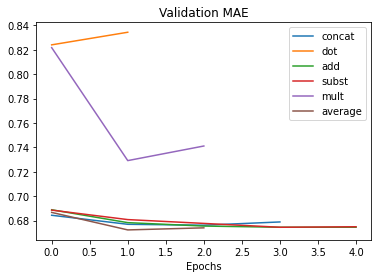

In [38]:
# comparing the models
import matplotlib.pyplot as plt 
plt.plot(epoch_concat, val_MAE_concat, label='concat')
plt.plot(epoch_dot, val_MAE_dot, label='dot')
plt.plot(epoch_add, val_MAE_add, label='add')
plt.plot(epoch_subb, val_MAE_sub, label='subst')
plt.plot(epoch_mult, val_MAE_mult, label='mult')
plt.plot(epoch_av, val_MAE_av, label='average')
plt.xlabel('Epochs')
plt.title('Validation MAE')
plt.legend() 
plt.show()   

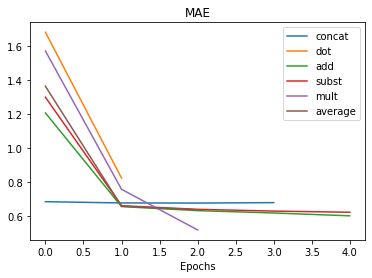

In [40]:
plt.plot(epoch_concat, val_MAE_concat, label='concat')
plt.plot(epoch_dot, MAE_dot, label='dot')
plt.plot(epoch_add, MAE_add, label='add')
plt.plot(epoch_subb, MAE_subb, label='subst')
plt.plot(epoch_mult, MAE_mult, label='mult')
plt.plot(epoch_av, MAE_av, label='average')
plt.xlabel('Epochs')
plt.title('MAE')
plt.legend() 
plt.show()  

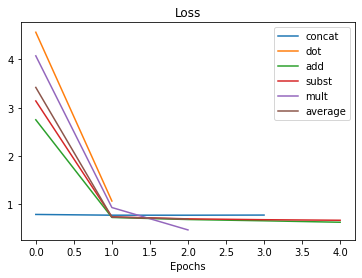

In [44]:
plt.plot(epoch_concat, val_loss_concat, label='concat')
plt.plot(epoch_dot, loss_dot, label='dot')
plt.plot(epoch_add, loss_add, label='add')
plt.plot(epoch_subb, loss_subb, label='subst')
plt.plot(epoch_mult, loss_mult, label='mult')
plt.plot(epoch_av, loss_av, label='average')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend() 
plt.show()  

In [25]:
# example prediction

In [51]:
# User 1
uid = 1
user_ratings = ratings[ratings.user_id==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
user_ratings.sort_values(by='rating', ascending=False)

User #1 has rated 232 movies (avg. rating = 4.4):


,user_id,movie_id,rating,unix_timestamp,title,genre,movie_index
16250,1,5060,5.0,964984002,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War,231
14053,1,2872,5.0,964981680,Excalibur (1981),Adventure|Fantasy,185
9066,1,1291,5.0,964981909,Indiana Jones and the Last Crusade (1989),Action|Adventure,89
9206,1,1298,5.0,964984086,Pink Floyd: The Wall (1982),Drama|Musical,90
14254,1,2948,5.0,964982191,From Russia with Love (1963),Action|Adventure|Thriller,190
...,...,...,...,...,...,...,...
12997,1,2617,2.0,964982588,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller,170
11663,1,2253,2.0,964981775,Toys (1992),Comedy|Fantasy,143
11991,1,2338,2.0,964983546,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller,148
12117,1,2389,2.0,964983094,Psycho (1998),Crime|Horror|Thriller,152


In [52]:
train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
user_ratings_train = train[train.user_id==uid]
print("User #{} has rated {} movies from train set (avg. rating = {:.1f}):".format(
    uid, len(user_ratings_train), user_ratings_train['rating'].mean(),
))
user_ratings_train.sort_values(by='rating', ascending=False)

User #1 has rated 186 movies from train set (avg. rating = 4.3):


,user_id,age,sex,occupation,zip_code,movie_id,rating,unix_timestamp,title,genre
90,1,24,M,technician,85711,1298,5.0,964984086,Pink Floyd: The Wall (1982),Drama|Musical
82,1,24,M,technician,85711,1256,5.0,964981442,Duck Soup (1933),Comedy|Musical|War
67,1,24,M,technician,85711,1136,5.0,964981327,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
9,1,24,M,technician,85711,157,5.0,964984100,Canadian Bacon (1995),Comedy|War
111,1,24,M,technician,85711,1804,5.0,964983034,"Newton Boys, The (1998)",Crime|Drama
...,...,...,...,...,...,...,...,...,...,...
152,1,24,M,technician,85711,2389,2.0,964983094,Psycho (1998),Crime|Horror|Thriller
148,1,24,M,technician,85711,2338,2.0,964983546,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller
76,1,24,M,technician,85711,1219,2.0,964983393,Psycho (1960),Crime|Horror
170,1,24,M,technician,85711,2617,2.0,964982588,"Mummy, The (1999)",Action|Adventure|Comedy|Fantasy|Horror|Thriller


In [211]:
# predicting for movies from the test data
movies_test=X_test.movie_index[X_test.user_id==uid] # index = movie_index rated by user uid
# prediction 
pred_concatenate=model_concatenate.predict([[uid]*len(movies_test),movies_test.index])
pred_dot=model_dot.predict([[uid]*len(movies_test),movies_test.index])
pred_add=model_add.predict([[uid]*len(movies_test),movies_test.index])
pred_substract=model_substract.predict([[uid]*len(movies_test),movies_test.index])
pred_multiply=model_multiply.predict([[uid]*len(movies_test),movies_test.index])
pred_average=model_average.predict([[uid]*len(movies_test),movies_test.index])

In [222]:
predictions=pd.DataFrame(movies_test.values)
predictions.columns=['movie_index']
predictions['model_concatenate']=pred_concatenate
predictions['model_dot']=pred_dot
predictions['model_add']=pred_add
predictions['model_substract']=pred_substract
predictions['model_multiply']=pred_multiply
predictions['model_average']=pred_average
predictions

,movie_index,model_concatenate,model_dot,model_add,model_substract,model_multiply,model_average
0,226,4.622072,3.448369,4.497911,4.680048,4.710207,4.615852
1,149,4.174574,3.374839,4.149758,4.235622,2.548493,4.288315
2,87,4.714343,3.574239,4.674882,4.706697,4.048813,4.871516
3,35,4.265672,3.424886,4.285356,4.378215,4.329502,4.293516
4,134,4.254668,3.436954,4.269300,4.443655,3.740063,4.296419
5,164,4.638810,3.393074,4.396836,4.629571,4.536667,4.686027
6,114,4.721183,3.341766,4.842363,4.900338,3.343884,4.867796
7,127,4.630707,3.383046,4.552131,4.639971,3.939409,4.658781
8,199,4.422797,3.372718,4.106859,4.453701,4.466158,4.657539
9,186,3.618361,3.390496,3.248651,3.475215,3.279625,3.580642


In [229]:
top5_model_concatenate=predictions.nlargest(5,'model_concatenate').movie_index
top5_model_dot=predictions.nlargest(5,'model_dot').movie_index
top5_model_add=predictions.nlargest(5,'model_add').movie_index
top5_model_substract=predictions.nlargest(5,'model_substract').movie_index
top5_model_multiply=predictions.nlargest(5,'model_multiply').movie_index
top5_model_average=predictions.nlargest(5,'model_average').movie_index

df=pd.DataFrame({'top5_model_concatenate': top5_model_concatenate.values, 'top5_model_dot':top5_model_dot.values, 'top5_model_add':  top5_model_add.values, 'top5_model_substract': top5_model_substract.values, 'top5_model_mulitply': top5_model_multiply.values, 'top5_model_average': top5_model_average.values})

In [230]:
df

,top5_model_concatenate,top5_model_dot,top5_model_add,top5_model_substract,top5_model_mulitply,top5_model_average
0,70,8,147,70,147,147
1,147,54,70,147,194,222
2,222,128,114,114,70,70
3,202,70,103,222,97,103
4,114,110,87,75,182,219


In [231]:
# movie 70 appears under the top 5 in all models
# movie 147 appears in 5 out of 6 models

In [276]:
movie_name=lambda movie: ratings.title[ratings.movie_index==movie]
movie_name(70).unique(), movie_name(147).unique()

(array(['Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'],
       dtype=object),
 array(['American History X (1998)'], dtype=object))

In [58]:
# lets now prepare the data using encoding;
# in kaggle is was stated: One embedding layer is required for each categorical variable, and the 
# embedding expects the categories to be ordinal encoded, although no relationship between the 
# categories is assumed
# previous code: columns=['user_id', 'movie_id', 'rating', 'title']
# train=train[columns], test=test[columns]

In [279]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder	
train=pd.read_pickle('/home/elena/Downloads/traindata.pkl')
test=pd.read_pickle('/home/elena/Downloads/testdata.pkl')

In [286]:
X_train.head()

,user_id,age,sex,occupation,zip_code,movie_id,unix_timestamp,title,genre,movie_index
97717,606,28,M,programmer,63044,3462,1171501099,Modern Times (1936),Comedy|Drama|Romance,1185
100124,610,22,M,student,21227,8914,1493845360,Primer (2004),Drama|Sci-Fi,2266
25952,180,22,F,administrator,60202,1196,1270237862,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,68
25871,178,26,M,other,49512,2231,1163673637,Rounders (1998),Drama,2183
97255,605,33,M,engineer,33716,1588,1277094877,George of the Jungle (1997),Children|Comedy,1495


In [288]:
# Make copy to avoid changing original data 
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
label_encoder.fit(ratings['movie_id'])
X_train_enc['movie_enc'] = label_encoder.transform(X_train['movie_id'])
X_test_enc['movie_enc'] = label_encoder.transform(X_test['movie_id'])

In [291]:
trained_model_concatenate_enc= model_concatenate.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 0.8405 - MAE: 0.7102 - val_loss: 0.7716 - val_MAE: 0.6741
Epoch 2/10
 - 3s - loss: 0.7169 - MAE: 0.6505 - val_loss: 0.7605 - val_MAE: 0.6691
Epoch 3/10
 - 3s - loss: 0.6811 - MAE: 0.6314 - val_loss: 0.7560 - val_MAE: 0.6662
Epoch 4/10
 - 3s - loss: 0.6581 - MAE: 0.6186 - val_loss: 0.7546 - val_MAE: 0.6629
Epoch 5/10
 - 3s - loss: 0.6352 - MAE: 0.6063 - val_loss: 0.7465 - val_MAE: 0.6647


In [293]:
val_MAE_concat

[0.6843906044960022,
 0.6769842505455017,
 0.6762386560440063,
 0.6789101958274841]

In [292]:
trained_model_dot_enc= model_dot.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 1.0845 - MAE: 0.8307 - val_loss: 1.0644 - val_MAE: 0.8252
Epoch 2/10
 - 3s - loss: 0.7937 - MAE: 0.6877 - val_loss: 0.9345 - val_MAE: 0.7540
Epoch 3/10
 - 3s - loss: 0.4244 - MAE: 0.4780 - val_loss: 0.9771 - val_MAE: 0.7702


In [294]:
val_MAE_dot # enc worse

[0.8241227269172668, 0.8344535231590271]

In [295]:
trained_model_add_enc= model_add.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 0.8692 - MAE: 0.7243 - val_loss: 0.7859 - val_MAE: 0.6828
Epoch 2/10
 - 3s - loss: 0.6755 - MAE: 0.6297 - val_loss: 0.7792 - val_MAE: 0.6766
Epoch 3/10
 - 3s - loss: 0.5949 - MAE: 0.5875 - val_loss: 0.7875 - val_MAE: 0.6843


In [296]:
val_MAE_add # enc worse

[0.6888989806175232,
 0.6783381700515747,
 0.6755317449569702,
 0.6745635271072388,
 0.674566388130188]

In [297]:
trained_model_substract_enc= model_substract.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 0.8699 - MAE: 0.7247 - val_loss: 0.7815 - val_MAE: 0.6821
Epoch 2/10
 - 3s - loss: 0.7082 - MAE: 0.6462 - val_loss: 0.7655 - val_MAE: 0.6736
Epoch 3/10
 - 4s - loss: 0.6593 - MAE: 0.6213 - val_loss: 0.7672 - val_MAE: 0.6671
Epoch 4/10
 - 3s - loss: 0.6175 - MAE: 0.5979 - val_loss: 0.7654 - val_MAE: 0.6714


In [298]:
val_MAE_sub

[0.6886200308799744,
 0.6808422207832336,
 0.6777119040489197,
 0.6745468974113464,
 0.6749667525291443]

In [299]:
trained_model_multiply_enc= model_multiply.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 0.9571 - MAE: 0.7655 - val_loss: 0.8793 - val_MAE: 0.7270
Epoch 2/10
 - 3s - loss: 0.4633 - MAE: 0.5195 - val_loss: 0.9436 - val_MAE: 0.7498


In [300]:
val_MAE_mult # enc worse

[0.8218462467193604, 0.7292081713676453, 0.7411757111549377]

In [301]:
trained_model_average_enc= model_average.fit(x=[X_train_enc.user_id, X_train_enc.movie_enc], y=y_train, batch_size=500,epochs=10, verbose=2, validation_data=[[X_test_enc.user_id, X_test_enc.movie_enc],y_test], callbacks=[es])

Train on 75627 samples, validate on 25209 samples
Epoch 1/10
 - 3s - loss: 0.8691 - MAE: 0.7232 - val_loss: 0.7829 - val_MAE: 0.6819
Epoch 2/10
 - 3s - loss: 0.7204 - MAE: 0.6524 - val_loss: 0.7659 - val_MAE: 0.6710
Epoch 3/10
 - 4s - loss: 0.6873 - MAE: 0.6349 - val_loss: 0.7639 - val_MAE: 0.6735


In [302]:
val_MAE_av

[0.6867244243621826, 0.6723760366439819, 0.674076497554779]

In [303]:
# in general, we obtain similar results if we index or encode the movie_id!